# Анализ оттока клиентов банка.

### Описание проекта
Цель - выделить сегменты отточных клиентов. Нужно проанализировать характеристики клиентов. Это позволит выделить сегменты клиентов, склонных уходить из банка, чтобы затем с помощью маркетингового воздействия на эти сегменты уменьшить количество отточных клиентов.

<a id='top'></a>
### План работы
1. [Обзор данных.](#section1)
2. [Предобработка данных.](#section2)
3. [Исследовательский анализ.](#section3)
4. [Проверка гипотез.](#section4)
5. [Сегментация.](#section5)
6. [Выводы.](#section6)

### Материалы
* [Презентация](https://disk.yandex.ru/i/zwCwsxl3zDpPXw)
* [Дашборд](https://public.tableau.com/views/_16892384680210/sheet2?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link)

<a id='section1'></a>
### Загрузка и первичное ознакомление с данными.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats as st

In [2]:
data = pd.read_csv('/datasets/bank_scrooge.csv')

In [3]:
data.head()

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


# Ознакомившись с данными, мы можем сказать, что некоторые колонки названы некорректно, имеются пропуски. Перейдем к предобработке.

<a id='section2'></a>
### Предобработка данных:
    - Проверить корректность наименований колонок;
    - Проверить соответствие типов данных;
    - Исследовать дубликаты;
    - Исследовать пропуски;
    - Исследовать выбросы;
    - Кодирование данных.
    
[Оглавление](#top)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


Приведем названия колонок к нижнему регистру и переименуем колонку `USERID`.

In [5]:
data.columns = data.columns.str.lower()
data.rename(columns={'userid': 'user_id'}, inplace=True)

Данные в столбце `age` лучше привести к целочисленнму типу. Но в данном столбце есть пропуски. Посмотрим сколько их.

In [6]:
print(f"Количество пропусков в столбце age: {data['age'].isnull().sum()}")
print(f"Процент пропусков в столбце age: {data['age'].isnull().sum() / len(data):.1%}")

Количество пропусков в столбце age: 26
Процент пропусков в столбце age: 0.3%


Процент пропущенных значений незначительный. Попробуем разобраться в природе пропусков. Посмотрим пропуски в разрезе по городам.

In [7]:
def barplot_show(df, x_axis, y_axis, my_title):
    '''
    Эта функция строит столбчатую диаграмму. На вход принимает датафрейм, значения по оси х и у, заголовок.
    '''
    df.plot(x=x_axis, y=y_axis, kind='bar', title=my_title);

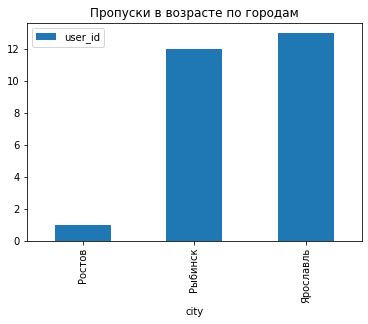

In [8]:
age_city = data[data['age'].isnull() == True].groupby('city').agg({'user_id': 'count'}).reset_index()
barplot_show(age_city, 'city', 'user_id', 'Пропуски в возрасте по городам')

В Ростове проущенных значений очень мало, в остальных городах примерно поровну. Посмотрим как распределены пропуски по полу.

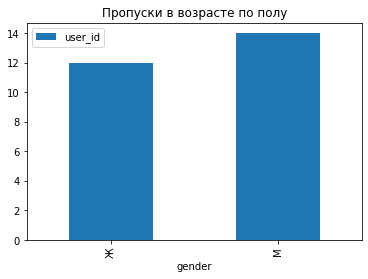

In [9]:
age_gender = data[data['age'].isnull() == True].groupby('gender').agg({'user_id': 'count'}).reset_index()
barplot_show(age_gender, 'gender', 'user_id', 'Пропуски в возрасте по полу')

Пропуски по полу распределены примерно поровну. Посмотрим в разрезе количества продуктов.

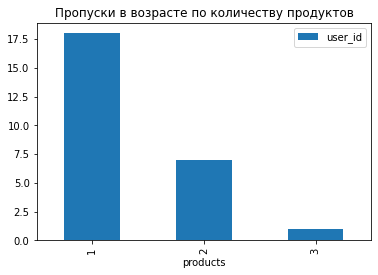

In [10]:
age_prod= data[data['age'].isnull() == True].groupby('products').agg({'user_id': 'count'}).reset_index()
barplot_show(age_prod, 'products', 'user_id', 'Пропуски в возрасте по количеству продуктов')

Пропусков больше у клиентов с меньшим количеством продуктов, которыми они пользуются, однако однозначно природу пропусков определить не удается. Можно предположить, что это технический сбой. Поскольку процент пропущенных значений в этом столбце невелик, мы можем удалить пропуски, а затем привести данные к целочисленному типу.

In [11]:
data = data.dropna(subset=['age'])
data['age'] = data['age'].astype('int')

Проверим данные на дубликаты.

In [12]:
data[data.duplicated()].head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn


Явных дубликатов не обнаружено. Посмотрим на неявные.

In [13]:
print(f"Количество уникальных значений в столбце user_id: {data['user_id'].nunique()}")
print(f"Количество дубликатов в столбце user_id: {data['user_id'].duplicated().sum()}")

Количество уникальных значений в столбце user_id: 9924
Количество дубликатов в столбце user_id: 50


Посмотрим на эти дубликаты.

In [14]:
duplicated_id = data.loc[data.user_id.duplicated(), 'user_id'].tolist()
id_dupl = data.query('user_id in (@duplicated_id)').sort_values(by='user_id')
id_dupl.head(10)

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
1893,116540,883.0,Рыбинск,Ж,55,1,362756.49,3,0,1,175920.48,1
7694,116540,887.0,Ярославль,Ж,38,0,NaN,1,0,1,119247.61,0
4866,117943,855.0,Рыбинск,Ж,32,6,1036832.93,4,1,1,107792.71,1
7542,117943,880.0,Ярославль,Ж,40,0,NaN,1,1,0,137718.93,0
5863,120258,908.0,Рыбинск,Ж,38,4,2213581.63,2,0,1,160327.77,1
5896,120258,905.0,Ярославль,М,30,0,NaN,1,1,1,146427.96,0
1411,123461,829.0,Ярославль,Ж,59,0,96222.44,2,0,1,102771.55,1
8638,123461,934.0,Рыбинск,М,34,0,NaN,2,1,0,291619.27,0
9775,124450,758.0,Рыбинск,Ж,36,0,73574.07,2,0,1,79963.59,0
8164,124450,859.0,Ярославль,Ж,38,6,516811.20,1,1,1,95144.63,1


In [15]:
id_dupl.groupby('city').agg({'user_id': 'count'})

,user_id
city,
Рыбинск,50
Ярославль,50


Дубликаты в столбце `user_id` вероятно связаны с тем, что клиентам из разных городов был присвоен один и тот же id. Поэтому, объединив столбцы user_id и city создадим новый столбец, который будет однозначно идентифицировать каждую строку нашего датасета.

In [16]:
data['id'] = data['user_id'].astype(str) + ', ' + data['city']
print(f"Количество уникальных значений в столбце id: {data['id'].nunique()}")
print(f"Количество строк в датафрейме: {len(data)}")

Количество уникальных значений в столбце id: 9974
Количество строк в датафрейме: 9974


In [17]:
print(f"Список уникальных значений в столбце city: {data['city'].unique()}")
print(f"Список уникальных значений в столбце gender: {data['gender'].unique()}")
print(f"Список уникальных значений в столбце credit_card: {data['credit_card'].unique()}")
print(f"Список уникальных значений в столбце last_activity: {data['last_activity'].unique()}")
print(f"Список уникальных значений в столбце churn: {data['churn'].unique()}")
print(f"Список уникальных значений в столбце equity: {data['equity'].unique()}")
print(f"Список уникальных значений в столбце products: {data['products'].unique()}")

Список уникальных значений в столбце city: ['Рыбинск' 'Ярославль' 'Ростов']
Список уникальных значений в столбце gender: ['Ж' 'М']
Список уникальных значений в столбце credit_card: [0 1]
Список уникальных значений в столбце last_activity: [1 0]
Список уникальных значений в столбце churn: [1 0]
Список уникальных значений в столбце equity: [1 5 0 4 3 2 6 7 8 9]
Список уникальных значений в столбце products: [2 3 1 4 5 0]


В других столбцах неявных дубликатов не обнаружено. 

В столбце `products` есть клиенты с нулевым значением. Проверим, нет ли здесь ошибок и посмотрим, нет ли у таких клиентов кредитных карт.

In [18]:
data.query('products == 0')[['credit_card']].sum()

credit_card    0
dtype: int64

Ошибки нет, у таких клиентов действительно нет кредитных карт. 

Посмотрим на клиентов с 0 продуктов.

In [19]:
data.query('products == 0')

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,id
8957,147837,962.0,Рыбинск,Ж,79,3,NaN,0,0,0,25063.96,1,"147837, Рыбинск"


В данных всего один пользователь с 0 в столбце `products`. Так как клиентом банка считаются те, кто имеет как минимум 1 продукт, мы можем удалить его из исследования.

In [20]:
data = data.query('products >= 1')

Посмотрим на пропуски в столбце `balance`.

In [21]:
print(f"Количество пропусков в столбце balance: {data['balance'].isnull().sum()}")
print(f"Процент пропусков в столбце balance: {data['balance'].isnull().sum() / len(data):.1%}")

Количество пропусков в столбце balance: 2278
Процент пропусков в столбце balance: 22.8%


Процент пропусков в данном столбце очень большой, удалить их мы не можем. Возможно это клиенты с нулевым балансом.

In [22]:
data['balance'].describe()

count    7.695000e+03
mean     8.272456e+05
std      1.980327e+06
min      0.000000e+00
25%      2.956987e+05
50%      5.242953e+05
75%      9.800512e+05
max      1.191136e+08
Name: balance, dtype: float64

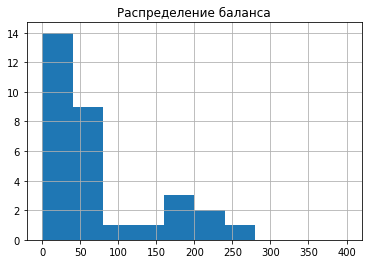

In [23]:
data['balance'].hist(bins=10, range=(0,400))
plt.title("Распределение баланса")
plt.show();

Клиенты с нулевым балансом в данных уже есть. Попытаемся определить природу пропусков.

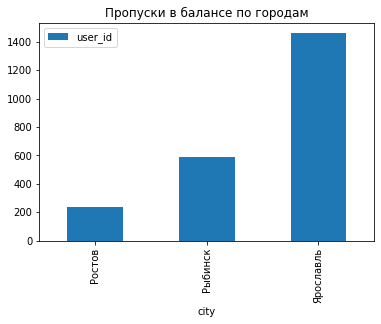

In [24]:
balance_city = data[data['balance'].isnull() == True].groupby('city').agg({'user_id': 'count'}).reset_index()
barplot_show(balance_city, 'city', 'user_id', 'Пропуски в балансе по городам')

Пропущенных значений больше всего в Ярославле. Посмотрим в разрезе наличия или отсутствия кредитной карты.

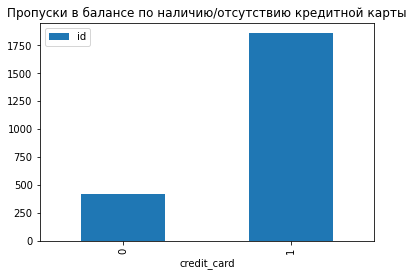

In [25]:
balance_card = data[data['balance'].isnull() == True].groupby('credit_card').agg({'id': 'count'}).reset_index()
barplot_show(balance_card, 'credit_card', 'id', 'Пропуски в балансе по наличию/отсутствию кредитной карты')

У клиентов, имеющих кредитную карту, пропусков больше, но они есть и у тех, кто не пользуется кредиткой. Посмотрим в разрезе количества баллов в собственности.

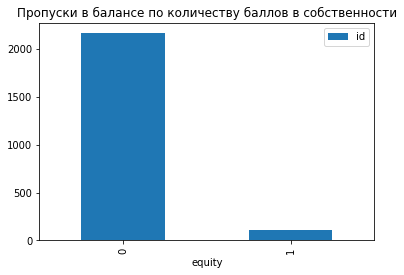

In [26]:
balance_equity = data[data['balance'].isnull() == True].groupby('equity').agg({'id': 'count'}).reset_index()
barplot_show(balance_equity, 'equity', 'id', 'Пропуски в балансе по количеству баллов в собственности')

Большая часть пропусков у клиентов с нулевым баллом в собственности. Тем не менее однозначно определить природу пропусков мы не можем. Можно предположить, что пропуски в столбце `balance` это технический сбой. Поскольку у нас нет информации, чтобы корректно заполнить пропуски, а пропусков значительное количество, оставим их как есть.

Посмотрим, есть ли выбросы в данных.


<div class="alert alert-success">
<b>Комментарий ревьюера:</b>☀️Спасибо за дополнительный анализ пропущенных значений ;)</div>

In [27]:
data.describe()

,user_id,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn
count,9973.000000,9973.000000,9973.000000,9973.000000,7.695000e+03,9973.000000,9973.000000,9973.000000,9.973000e+03,9973.000000
mean,171757.616966,848.671212,42.730773,2.630803,8.272456e+05,1.871653,0.680237,0.522912,1.477991e+05,0.182292
std,33696.365256,65.393153,12.175166,1.980060,1.980327e+06,0.792547,0.466408,0.499500,1.392871e+05,0.386105
min,94561.000000,642.000000,18.000000,0.000000,0.000000e+00,1.000000,0.000000,0.000000,2.546300e+03,0.000000
25%,142757.000000,802.000000,33.000000,0.000000,2.956987e+05,1.000000,0.000000,0.000000,7.525202e+04,0.000000
50%,172651.000000,853.000000,40.000000,3.000000,5.242953e+05,2.000000,1.000000,1.000000,1.196431e+05,0.000000
75%,201164.000000,900.000000,51.000000,4.000000,9.800512e+05,2.000000,1.000000,1.000000,1.745000e+05,0.000000
max,229145.000000,1000.000000,86.000000,9.000000,1.191136e+08,5.000000,1.000000,1.000000,1.395064e+06,1.000000


Проверим выбросы в столбцах `age` и `est_salary`.

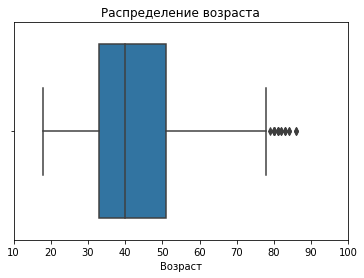

In [28]:
sns.boxplot(x=data["age"])
plt.title('Распределение возраста')
plt.xlabel('Возраст')
plt.xlim(10, 100);

In [29]:
np.percentile(data['age'], [90, 95, 99])

array([61., 65., 73.])

Не более 1% клиентов старше 73 лет. Поскольку ограничений по возрасту для пользования услугами банка нет, то трогать их не будем.

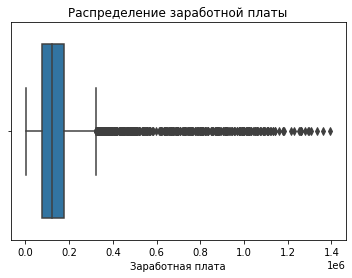

In [30]:
sns.boxplot(x=data["est_salary"])
plt.title('Распределение заработной платы')
plt.xlabel('Заработная плата');

In [31]:
np.percentile(data['est_salary'], [90, 95, 99])

array([242322.348 , 316366.936 , 886343.7136])

Не более 1% клиентов имеют заработную плату выше 886322.5299 рублей. Посмотрим из какого они города.

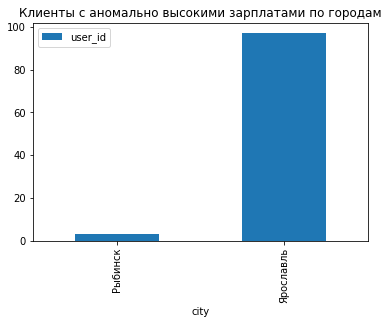

In [32]:
salary_threshold = data['est_salary'].quantile(0.99).astype('int')
salary_max = data.query('est_salary > @salary_threshold')
salary_city = salary_max.groupby('city').agg({'user_id': 'count'}).reset_index()
barplot_show(salary_city, 'city', 'user_id', 'Клиенты с аномально высокими зарплатами по городам')

Большинство клиентов с аномально высокими зарплатами из Ярославля. Несмотря на то, что такие значения нехарактерны для этого региона, у нас нет причины удалять таких клиентов из анализа.

Также в данных есть клиенты с аномально низкими зарплатами (менее 5000). Посмотрим на них.

In [33]:
wage_min = 5000
salary_min = data.query('est_salary < @wage_min')
print(f"Количество клиентов с аномально низкими зарплатами: {len(salary_min)}")

Количество клиентов с аномально низкими зарплатами: 2


In [34]:
salary_min

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,id
2186,201407,938.0,Рыбинск,Ж,69,1,325483.52,3,0,1,3487.33,0,"201407, Рыбинск"
8783,114221,948.0,Ярославль,Ж,26,1,77092.89,1,1,0,2546.30,0,"114221, Ярославль"


Можно предположить, что у таких клиентов есть другой источник дохода, неизвестный банку. Поскольку таких клиентов незначительное количество, у нас нет оснований для их удаления.

Нам нужно применить к столбцам `city` и `gender` one-hot кодирование, чтобы в дальнейшем анализе мы могли применять среднее и смотреть корреляции числовых показателей с категориальными. Создадим копию датафрейма и применим к нему кодирование. 

In [35]:
data_cod = data
data_cod = pd.get_dummies (data_cod, columns=['city', 'gender'])
data_cod = data_cod.rename(columns = ({'city_Ростов':'Ростов', 'city_Рыбинск':'Рыбинск','city_Ярославль':'Ярославль', 'gender_Ж':'female', 'gender_М':'male'}))
data_cod.head()

,user_id,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,id,Ростов,Рыбинск,Ярославль,female,male
0,183012,850.0,25,1,59214.82,2,0,1,75719.14,1,"183012, Рыбинск",0,1,0,1,0
1,146556,861.0,37,5,850594.33,3,1,0,86621.77,0,"146556, Рыбинск",0,1,0,1,0
2,120722,892.0,30,0,NaN,1,1,1,107683.34,0,"120722, Рыбинск",0,1,0,1,0
3,225363,866.0,51,5,1524746.26,2,0,1,174423.53,1,"225363, Ярославль",0,0,1,1,0
4,157978,730.0,34,5,174.00,1,1,0,67353.16,1,"157978, Ярославль",0,0,1,0,1


На этапе предобработки мы:
- Проверили корректность названий столбцов и переименовали столбцы `USERID` и `EST_SALARY` в более удобные. 
- Проверили соответствие типов данных и поменяли тип в столбце `age` на целочисленный.
- Исследовав дубликаты, мы выяснили, что в столбце user_id они есть. И вероятно связаны с тем, что клиентам из разных городов был присвоен один и тот же id. Мы создали новый столбец с id, который будет однозначно идентифицировать каждую строку нашего датасета
- Пропуски мы обнаружили в столбцах `age` и `balance`. Вероятно они связаны с техническими сбоями. В столбце `age` их незначительное количество (0.3%) и мы их удалили. В столбце `balance` их много (22.8%). Поскольку корректно заполнить их мы не можем, то оставляем их без изменений.
- Выбросы в столбце `age` и `est_salary` мы оставили без изменений.
- К столбцам `city` и `gender` мы применили one-hot кодирование, создав новые столбцы, небходимые нам для анализа.

Данные готовы к дальнейшей работе.

<a id='section3'></a>
### Исследовательский анализ данных:
    - Анализ распределения;
    - Категоризация на основе распределения;
    - Анализ корреляции;
    - Составление портретов типичных клиентов;
    - Промежуточные выводы.
    
[Оглавление](#top)

Нам нужно разделить значения столбца `age` на категории. Для этого посмотрим на распределение возраста в разрезе оттока.

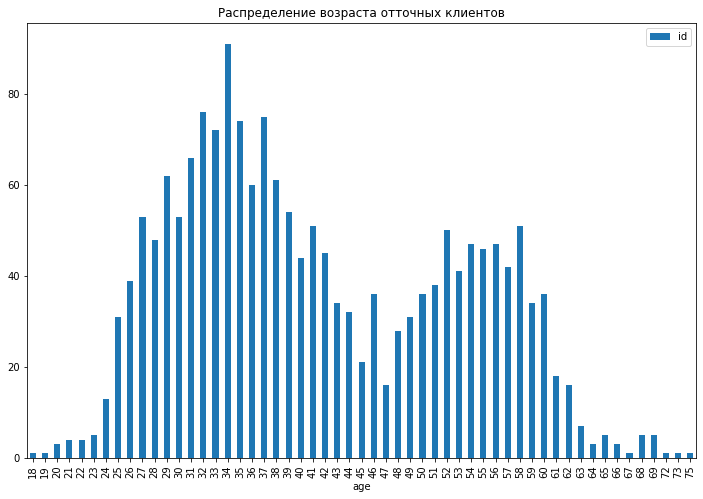

In [36]:
churn_1 = data.query('churn == 1')
age_churn = churn_1.groupby('age').agg({'id': 'count'}).reset_index().plot(x='age', y='id', kind='bar', figsize = (12,8), title='Распределение возраста отточных клиентов')


Из графика можем выделить следующие категории:
- 18-25 лет
- 26-46 лет
- 47-60 лет
- 61 и старше

Напишем функцию, которая назначит категории и добавим столбцы с категориями в таблицу.

In [37]:
def categorize_age(age):
    '''
    Эта функция назначает категории возраста. На вход принимает значение возраста.
    '''
    try:
        if 18 <= age <= 25:
            return '18-25'
        elif 26 <= age <= 46:
            return '26-46'
        elif 47 <= age <= 60:
            return '47-60'
        elif age >= 61:
            return '61 и старше'
    except:
        pass

In [38]:
data['age_category'] = data['age'].apply(categorize_age)
data_cod['age_category'] = data['age_category']

По такому же принципу разделим на категории столбец `balance`.

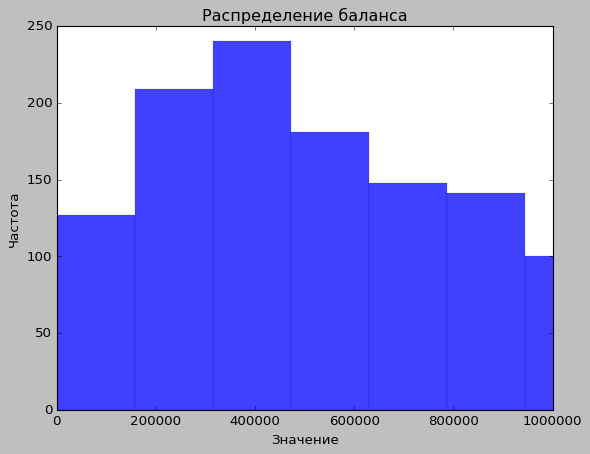

In [39]:
plt.style.use('classic')
sns.histplot(x='balance', data=churn_1)
plt.xlim(0, 1000000)
plt.title('Распределение баланса')
plt.xlabel('Значение')
plt.ylabel('Частота')
plt.show()

Из графика можем выделить следующие категории:
- от 0 до 180 тысяч
- 180 - 600 тысяч
- более 600 тысяч

Напишем функцию, которая назначит категории и добавим столбцы с категориями в таблицу.

In [40]:
def categorize_balance(balance):
    '''
    Эта функция назначает категории баланса. На вход принимает значение баланса.
    '''
    try:
        if 0 <= balance <= 180000:
            return '0-180'
        elif 180000 < balance <= 600000:
            return '180-600'
        elif balance > 600000:
            return 'более 600'
    except:
        pass

In [41]:
data['balance_category'] = data['balance'].apply(categorize_balance)

То же самое проделаем с баллами кредитного скоринга.

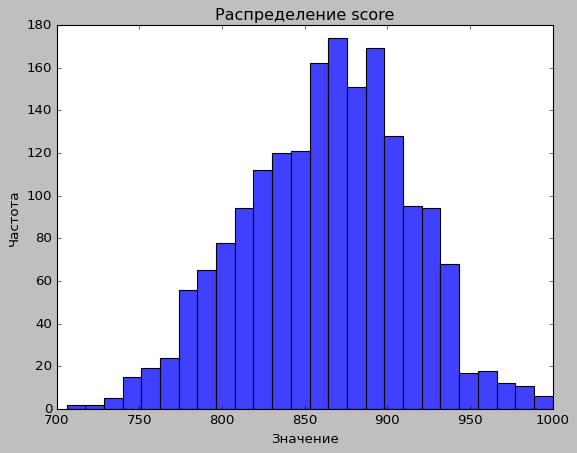

In [42]:
plt.style.use('classic')
sns.histplot(x='score', data=churn_1)
plt.title('Распределение score')
plt.xlabel('Значение')
plt.ylabel('Частота')
plt.show()

Можно выделить следующие категории:
- до 770
- 770-940
- 940-1000

In [43]:
def categorize_score(score):
    '''
    Эта функция назначает категории баллов кредитного скоринга. На вход принимает баллы.
    '''
    try:
        if 0 <= score <= 770:
            return 'C'
        elif 770 < score <= 940:
            return 'B'
        elif score > 940:
            return 'A'
    except:
        pass

In [44]:
data['score_category'] = data['score'].apply(categorize_score)

Применим к столбцу `age_category` one-hot кодирование.

In [45]:
data_cod = pd.get_dummies (data_cod, columns=['age_category'])

Теперь мы можем посмотреть корреляцию оттока с другими признаками.

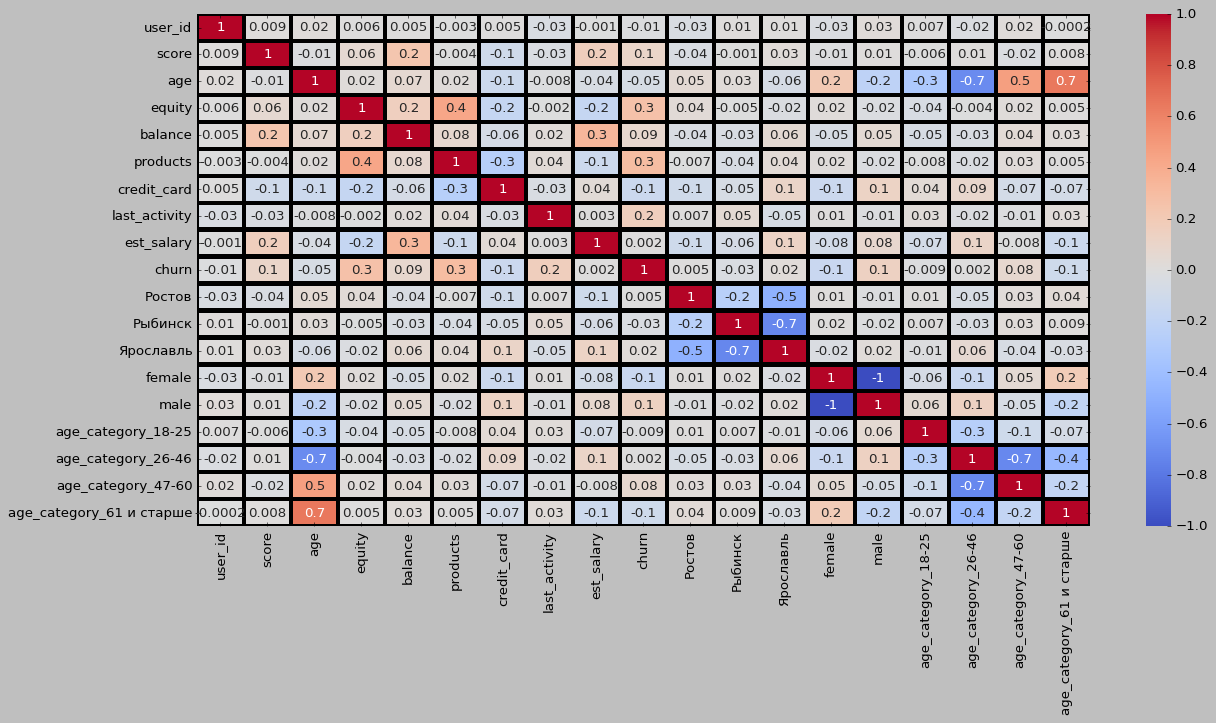

In [46]:
plt.figure(figsize=(18, 8))
sns.heatmap(data_cod.corr(), annot = True, fmt='.1g', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', linewidths=3, linecolor='black');

Из графика мы видим, что у параметра `churn` очень слабая корреляция с остальными параметрами (не превышает 0.3). Но среди можно выделить параметры с наибольшей корреляцией:
- `equity`, `products` - корреляция 0.3
- `last_activity` - корреляция 0.2
- `score`, `gender` (female, male) - корреляция -0.1 и 0.1 соответственно
- `credit_card` - корреляция -0.1
- `balance`, `age_category_47-60` - корреляция 0.08

Рассмотрим эти параметры в разрезе оттока клиентов.

In [47]:
def show_values_on_bars(axs):
    '''
    Это готовая функция из интернета для того, чтобы отобразить значения на графиках.
    '''
    def _show_on_single_plot(ax):
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.0f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

In [48]:
def barplot_show_2(x_axis, y_axis, df, hue_column, title, x_label, y_label):
    '''
    Эта функция строит столбчатую диаграмму. Принимает на вход значение по осям х и у, датафрейм, заголовок, подписи к осям.
    '''
    sns.set_style('dark')
    plt.figure(figsize=(10, 8))
    ax = sns.barplot(x=x_axis, y=y_axis, data=df, hue=hue_column)
    show_values_on_bars(ax)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xticks(rotation=45)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid()
    plt.show()    

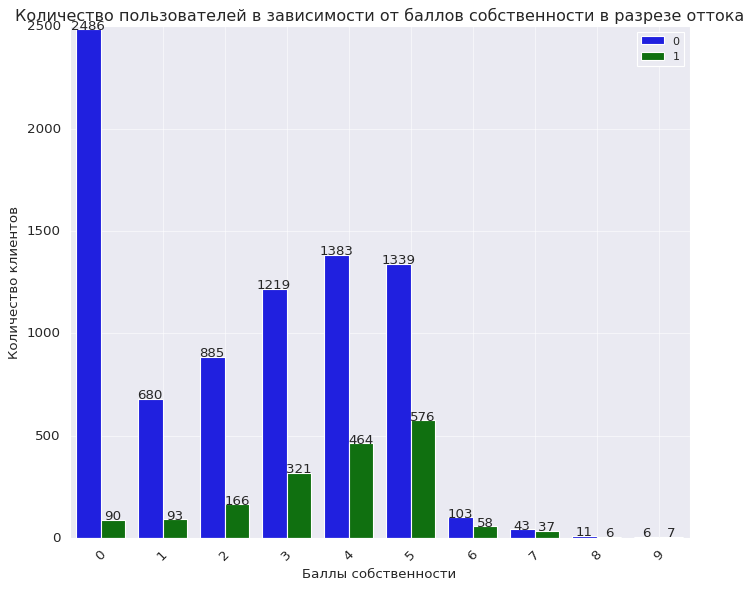

In [49]:
equity_churn = data.groupby(['equity', 'churn'], as_index = False)[['id']].nunique()
equity_churn.columns = ['equity', 'churn', 'count']
barplot_show_2('equity', 'count', equity_churn, 'churn', 'Количество пользователей в зависимости от баллов собственности в разрезе оттока', 'Баллы собственности', 'Количество клиентов')

У большинства отточных пользователей 5 баллов собственности. Пользователи, не склонные к уходу, имеют в основном 0 баллов. Клиентов, имеющих больше 6 баллов, очень мало.

Посмотрим на количество продуктов.

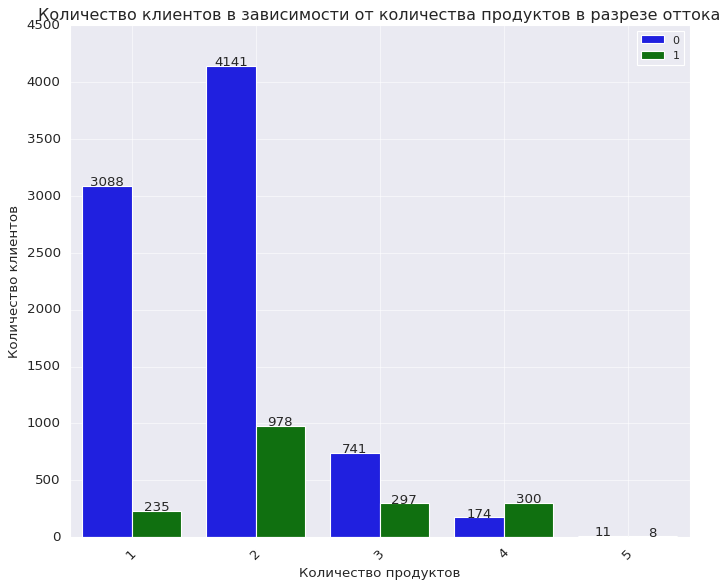

In [50]:
products_churn = data.groupby(['products', 'churn'], as_index = False)[['id']].nunique()
products_churn .columns = ['products', 'churn', 'count']
barplot_show_2('products', 'count', products_churn, 'churn', 'Количество клиентов в зависимости от количества продуктов в разрезе оттока', 'Количество продуктов', 'Количество клиентов')

Большинство отточных пользователей пользуются 2 продуктами. Клиенты, несклонные к уходу также чаще используют 2 продукта. Клиентов, пользующихся 5 продуктами, очень мало.

Посмотрим на `last_activity`.

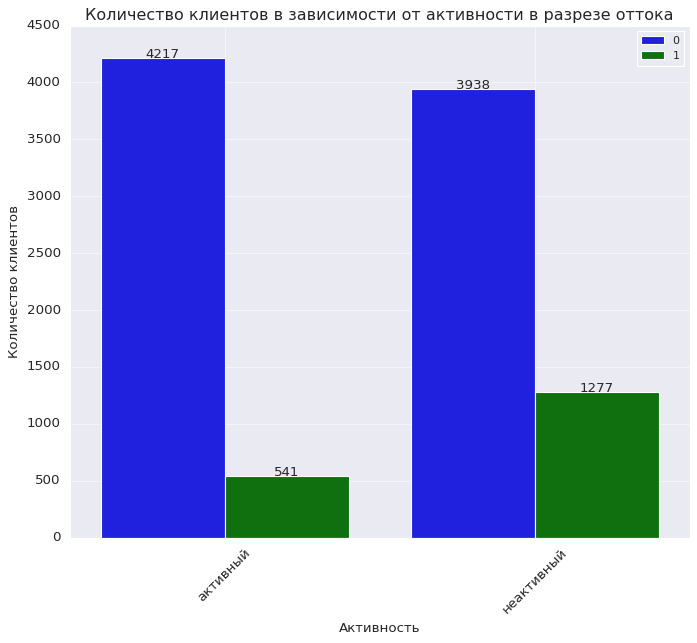

In [51]:
last_activity_churn = data.groupby(['last_activity', 'churn'], as_index = False)[['id']].nunique()
last_activity_churn.columns = ['last_activity', 'churn', 'count']
last_activity_churn['last_activity'] = last_activity_churn['last_activity'].apply(lambda x: 'неактивный' if x == 1 else 'активный')
barplot_show_2('last_activity', 'count', last_activity_churn, 'churn', 'Количество клиентов в зависимости от активности в разрезе оттока', 'Активность', 'Количество клиентов')

Отточные клиенты чаще неактивны. У клиентов, несклонных к уходы, активность распределена примерно поровну.

Посмотрим на `score`.

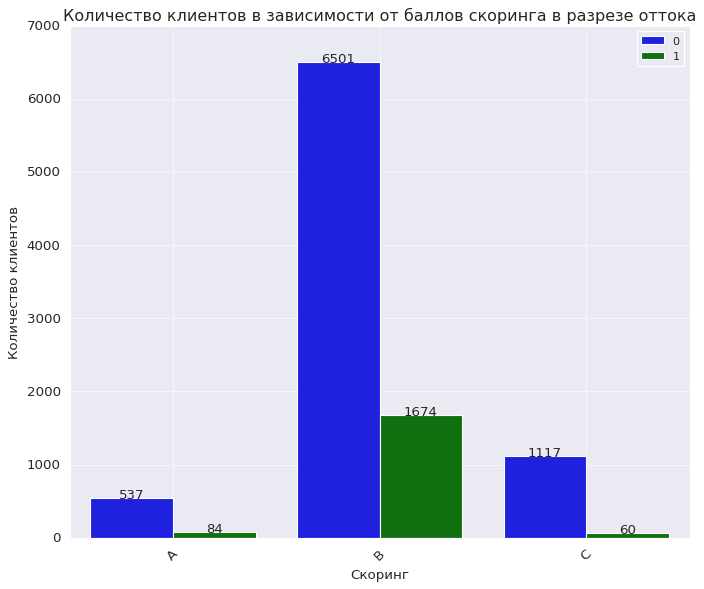

In [52]:
score_churn = data.groupby(['score_category', 'churn'], as_index = False)[['id']].nunique()
score_churn .columns = ['score_category', 'churn', 'count']
barplot_show_2('score_category', 'count', score_churn, 'churn', 'Количество клиентов в зависимости от баллов скоринга в разрезе оттока', 'Скоринг', 'Количество клиентов')

И отточные и неотточные клиенты чаще имеют рейтинг 770-940.

Посмотрим на `gender`.

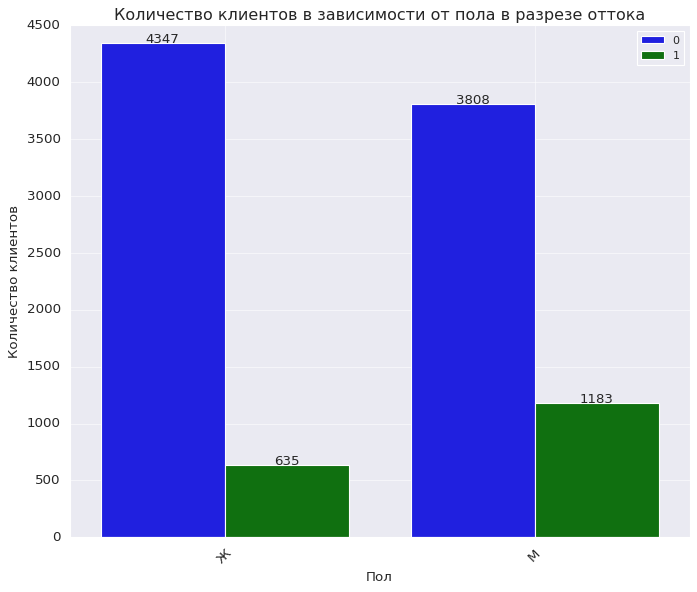

In [53]:
gender_churn = data.groupby(['gender', 'churn'], as_index = False)[['id']].nunique()
gender_churn .columns = ['gender', 'churn', 'count']
barplot_show_2('gender', 'count', gender_churn, 'churn', 'Количество клиентов в зависимости от пола в разрезе оттока', 'Пол', 'Количество клиентов')

Большинство отточных клиентов - мужчины. Клиенты, несклонные к уходу, чаще женщины. 

Посмотрим на `credit_card`.

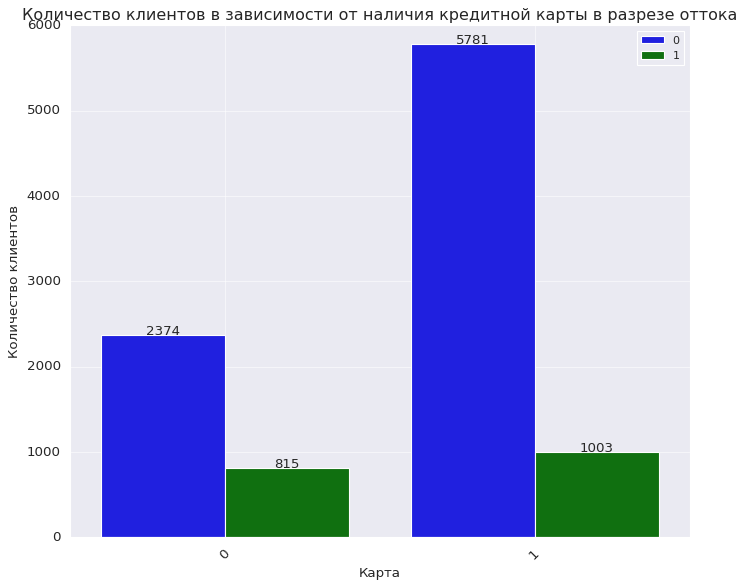

In [54]:
card_churn = data.groupby(['credit_card', 'churn'], as_index = False)[['id']].nunique()
card_churn .columns = ['credit_card', 'churn', 'count']
barplot_show_2('credit_card', 'count', card_churn, 'churn', 'Количество клиентов в зависимости от наличия кредитной карты в разрезе оттока', 'Карта', 'Количество клиентов')

Количество отточных клиентов по наличию кредитной карты распределено примерно поровну, но немного чаще имеют карту. Клиенты, несклонные к уходу чаще имеют кредитную карту.

Посмотрим на `balance`.

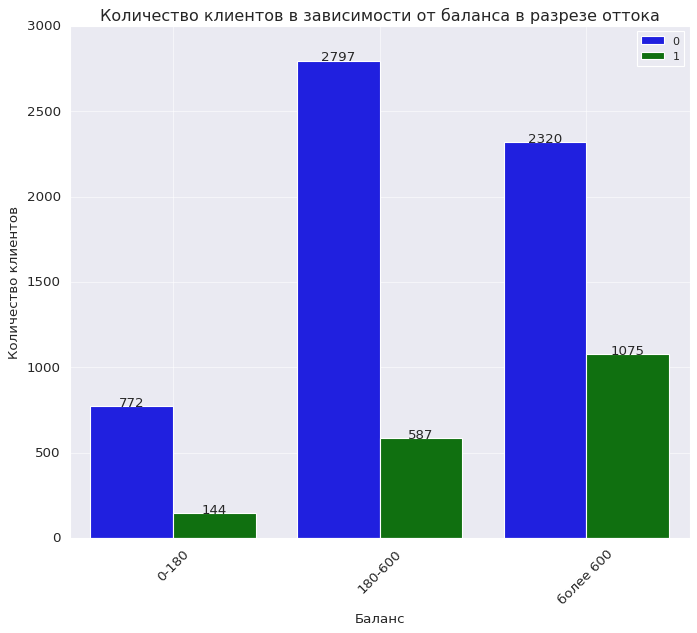

In [55]:
balance_churn = data.groupby(['balance_category', 'churn'], as_index = False)[['id']].nunique()
balance_churn .columns = ['balance_category', 'churn', 'count']
barplot_show_2('balance_category', 'count', balance_churn, 'churn', 'Количество клиентов в зависимости от баланса в разрезе оттока', 'Баланс', 'Количество клиентов')

Большинство отточных клиентов имеют баланс более 600 тысяч рублей. Клиенты, несклонные к уходу, чаще имеют баланс в диапазоне 180-600 тысяч.

Посмотрим на `age`.

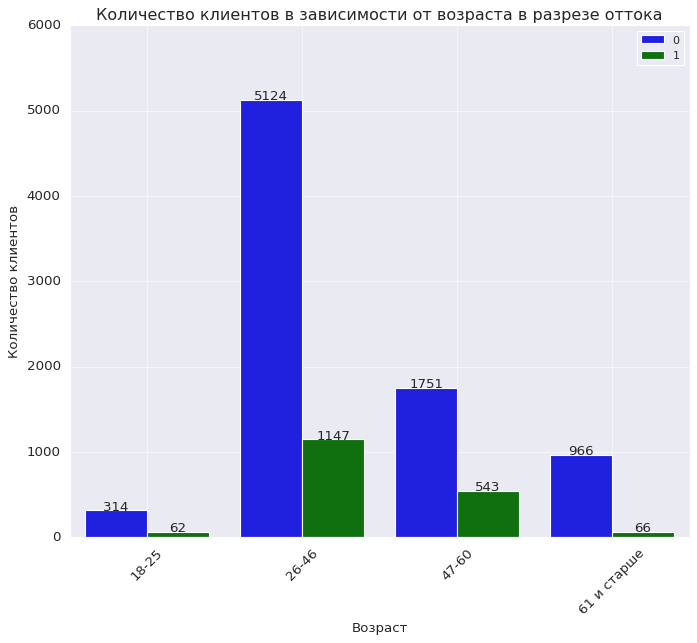

In [56]:
age_churn = data.groupby(['age_category', 'churn'], as_index = False)[['id']].nunique()
age_churn .columns = ['age_category', 'churn', 'count']
barplot_show_2('age_category', 'count', age_churn, 'churn', 'Количество клиентов в зависимости от возраста в разрезе оттока', 'Возраст', 'Количество клиентов')

Большинство клиентов, как отточных, так и несклонных к уходу, находится в диапазоне 26-46 лет.

Таким образом, мы можем составить портреты клиентов.

1. Отточные клиенты:
- Имеют 5 баллов в собственности.
- Пользуются двумя продуктами.
- Неактивны.
- Имеют кредитный рейтинг в диапазоне 770-940.
- Чаще мужчины.
- Могут иметь и не иметь кредитную карту, но немного чаще имеют.
- Имеют баланс более 600 тысяч рублей.
- Находятся в возрасте 26-46 лет.

2. Клиенты, не склонные к уходу:
- Имеют 0 баллов в собственности.
- Пользуются двумя продуктами.
- Могут быть как активны, так и нет.
- Имеют кредитный рейтинг в диапазоне 770-940.
- Чаще женщины.
- Имеют кредитную карту.
- Имеют баланс 180-600 тысяч рублей.
- Находятся в возрасте 26-46 лет.

Мы разделили на категории столбцы `age`, `balance` и `score` на основе распределения данных.
Проверили корреляцию оттока с другими параметрами, она оказалась незначительной (не более 0.3).
Затем мы исследовали параметры с наибольшим значением корреляции в разрезе оттока и составили портреты клиентов, склонных и несклонных к уходу из банка. Эти характеристики помогут нам в дальнейшем выделить сегменты.

<a id='section4'></a>
### Проверка гипотез:
    - Проверить различается ли доход между ушедшими и оставшимися клиентами;
    - Проверить различается ли количество используемых продуктов между ушедшими и оставшимися клиентами;
    - Проверить различие в возрасте между ушедшими и оставшимися клиентами.
    
[Оглавление](#top)

Прежде чем выбрать метод для проверки гипотез, посмотрим на распределение нужных нам признаков в зависимоти о оттока. Напишем функцию для построения графиков распределения.

In [57]:
def violinplot_show(x_axis, y_axis, df, my_title, x_label):
    '''
    Эта функция строит «график-скрипку». На вход принимает значения по оси х и у, датафрейм, заголовок и название оси х.
    '''
    sns.violinplot(x=x_axis, y=y_axis, data=df)
    plt.title(my_title)
    plt.xlabel(x_label)
    plt.ylabel(None)
    plt.show();

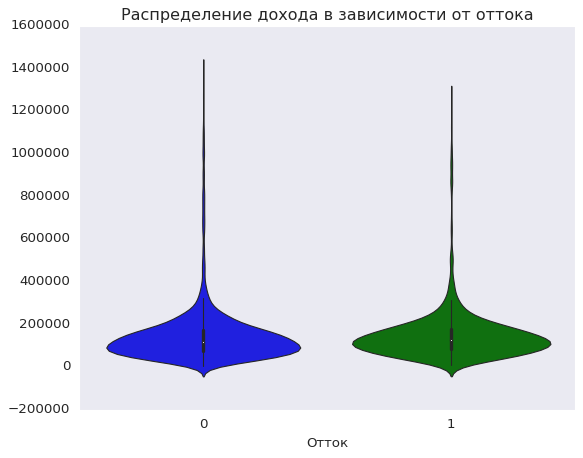

In [58]:
violinplot_show('churn', 'est_salary', data, 'Распределение дохода в зависимости от оттока', 'Отток')

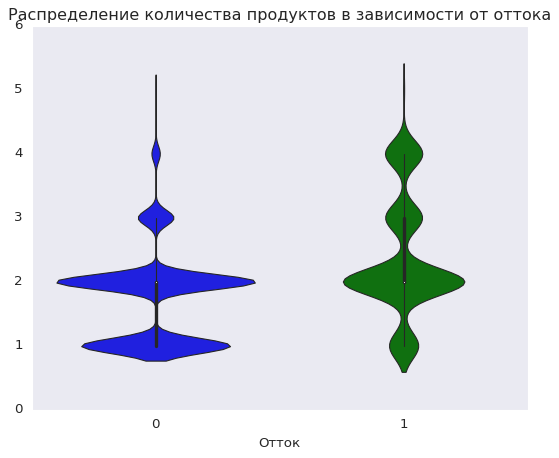

In [59]:
violinplot_show('churn', 'products', data, 'Распределение количества продуктов в зависимости от оттока', 'Отток')

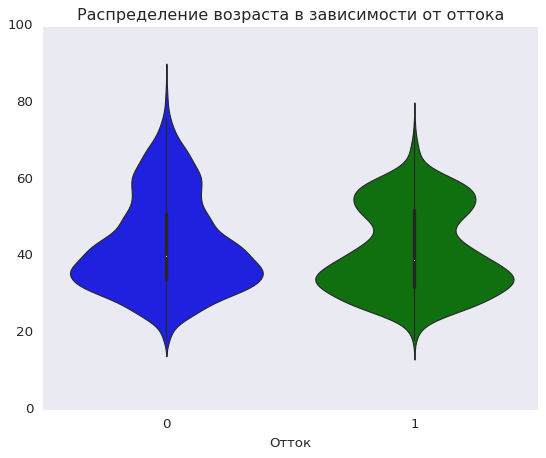

In [60]:
violinplot_show('churn', 'age', data, 'Распределение возраста в зависимости от оттока', 'Отток')

Распределения параметров похожи. Поскольку мы будем проверять гипотезы на независимых друг от друга выборках, мы будем использовать метод для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам - `ttest_ind`.

Значение alpha примем за 0.001, так как у нас достаточно большое количество данных.

Проверка гипотезы: различается ли доход между ушедшими и оставшимися клиентами.
```
H_0: Доход ушедших клиентов = доходу оставшихся клиентов`
H_1: Доход ушедших клиентов ≠ доходу оставшихся клиентов`
alpha = 0.001
```

In [61]:
churn_0 = data.query('churn == 0')
salary_churn_1 = churn_1['est_salary']
salary_churn_0 = churn_0['est_salary']
results = st.ttest_ind(salary_churn_1, salary_churn_0, equal_var=False)

alpha = 0.001
print('p-value:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-value: 0.8354803526840116
Не получилось отвергнуть нулевую гипотезу


Разницы в доходе между ушедшими и оставшимися клиентами не выявлено.

Проверка гипотезы: различается ли количество используемых продуктов между ушедшими и оставшимися клиентами.
```
H_0: Количество используемых продуктов ушедших клиентов = количеству используемых продуктов оставшихся клиентов`
H_1: Количество используемых продуктов ушедших клиентов ≠ количеству используемых продуктов оставшихся клиентов`
alpha = 0.001
```

In [62]:
product_churn_1 = churn_1['products']
product_churn_0 = churn_0['products']
results = st.ttest_ind(product_churn_1, product_churn_0, equal_var=False)

alpha = 0.001
print('p-value:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-value: 1.2671065900765871e-138
Отвергаем нулевую гипотезу


Проверка показала, что есть разница между количеством используемых продуктов между ушедшими и оставшимися клиентами.

Проверка гипотезы: различается ли возраст между ушедшими и оставшимися клиентами.
```
H_0: Возраст ушедших клиентов = возрасту оставшихся клиентов`
H_1: Возраст ушедших клиентов ≠ возрасту оставшихся клиентов`
alpha = 0.001
```

In [63]:
age_churn_1 = churn_1['age']
age_churn_0 = churn_0['age']
results = st.ttest_ind(age_churn_1, age_churn_0, equal_var=False)

alpha = 0.001
print('p-value:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-value: 7.536127357312234e-08
Отвергаем нулевую гипотезу


Проверка показала, что есть разница в возрасте между ушедшими и оставшимися клиентами.

Таким образом, проверив гипотезы мы можем сказать, что:
* Статистически значимой разницы в доходе между ушедшими и оставшимися клиентами нет.
* Между количеством используемых продуктов между ушедшими и оставшимися клиентами есть статистически значимая разница.
* Есть статистически значимая разница в возрасте между ушедшими и оставшимися клиентами.

<a id='section5'></a>
### Сегментация:
    - Формирование сегментов;
    - Проверка на пересечение;
    - Выводы.
    
[Оглавление](#top)

На основании исследовательского анализа мы выделили ряд признаков, характерных для отточных клиентов. Теперь, используя эти признаки, можем выделить сегменты отточных клиентов.

In [64]:
features = ['equity == 5', 'products == 2', 'last_activity == 0', '770 <= score <= 940', 'gender == "М"', 'credit_card == 1', 'balance > 600000', '26 <= age <= 46']
cols = ['features', 'seg_v', 'churn_cnt']
lst = []
for i in features:
    d = data.query(i)
    lst.append([i, len(d), d['churn'].sum()])
df = pd.DataFrame(lst, columns=cols)
df['churn_mean'] = round(df['churn_cnt'] / df['seg_v'] * 100, 1)
df.sort_values(by=['churn_mean', 'churn_cnt'], ascending=False)

,features,seg_v,churn_cnt,churn_mean
6,balance > 600000,3395,1075,31.7
0,equity == 5,1915,576,30.1
4,"gender == ""М""",4991,1183,23.7
3,770 <= score <= 940,8199,1675,20.4
1,products == 2,5119,978,19.1
7,26 <= age <= 46,6271,1147,18.3
5,credit_card == 1,6784,1003,14.8
2,last_activity == 0,4758,541,11.4


Сравним процент оттока по этим сегментам с процентом оттока по банку в целом.

In [65]:
print(f"Процент оттока клиентов по банку: {round(data['churn'].sum() / len(data) * 100, 1)}")

Процент оттока клиентов по банку: 18.2


Процент оттока клиентов выше, чем по банку в целом по следующим признакам:
- balance > 600000
- equity == 5
- gender == "М"
- 770 <= score <= 940
- products == 2	
- 26 <= age <= 46	

Попробуем выделить сегменты клиентов, объединив признаки с наибольшим процентом оттока.

Сегмент №1: Мужчины с балансом более 600 тысяч рублей.

In [66]:
seg_1 = data.query('balance > 600000 and gender == "М"')
print(f"Объем сегмента 1: {len(seg_1)}")
print(f"Количество отточных клиентов в сегменте 1: {seg_1['churn'].sum()}")
print(f"Процент отточных клиентов в сегменте 1: {round(seg_1['churn'].sum() / len(seg_1) * 100, 1)}")

Объем сегмента 1: 1701
Количество отточных клиентов в сегменте 1: 704
Процент отточных клиентов в сегменте 1: 41.4


Сегмент №2: Мужчины от 26 до 46 лет с количеством балов собственности 5.

In [67]:
seg_2 = data.query('gender == "М" and 26 <= age <= 46 and equity == 5')
print(f"Объем сегмента 2: {len(seg_2)}")
print(f"Количество отточных клиентов в сегменте 2: {seg_2['churn'].sum()}")
print(f"Процент отточных клиентов в сегменте 2: {round(seg_2['churn'].sum() / len(seg_2) * 100, 1)}")

Объем сегмента 2: 688
Количество отточных клиентов в сегменте 2: 269
Процент отточных клиентов в сегменте 2: 39.1


Сегмент №3: Клиенты в возрасте от 26 до 46 лет с количеством баллов собственности 5.

In [68]:
seg_3 = data.query('26 <= age <= 46 and equity == 5')
print(f"Объем сегмента 3: {len(seg_3)}")
print(f"Количество отточных клиентов в сегменте 3: {seg_3['churn'].sum()}")
print(f"Процент отточных клиентов в сегменте 3: {round(seg_3['churn'].sum() / len(seg_3) * 100, 1)}")

Объем сегмента 3: 1217
Количество отточных клиентов в сегменте 3: 380
Процент отточных клиентов в сегменте 3: 31.2


Сегмент №4: Мужчины с балансом более 600000, пользующиеся 2 продуктами банка.

In [69]:
seg_4 = data.query('products == 2 and gender == "М" and balance > 600000')
print(f"Объем сегмента 4: {len(seg_4)}")
print(f"Количество отточных клиентов в сегменте 4: {seg_4['churn'].sum()}")
print(f"Процент отточных клиентов в сегменте 4: {round(seg_4['churn'].sum() / len(seg_4) * 100, 1)}")

Объем сегмента 4: 1035
Количество отточных клиентов в сегменте 4: 389
Процент отточных клиентов в сегменте 4: 37.6


Сегмент №5: Клиенты в возрасте от 26 до 46 лет с балансом более 600 тысяч рублей.

In [70]:
seg_5 = data.query('26 <= age <= 46 and balance > 600000')
print(f"Объем сегмента 5: {len(seg_5)}")
print(f"Количество отточных клиентов в сегменте 5: {seg_5['churn'].sum()}")
print(f"Процент отточных клиентов в сегменте 5: {round(seg_5['churn'].sum() / len(seg_5) * 100, 1)}")

Объем сегмента 5: 2012
Количество отточных клиентов в сегменте 5: 679
Процент отточных клиентов в сегменте 5: 33.7


Проверим пересекаются ли клиенты в сегментах.

In [71]:
cross = seg_1.merge(seg_2, on='id', how='inner')
cross = cross.merge(seg_3, on='id', how='inner')
cross = cross.merge(seg_4, on='id', how='inner')
cross = cross.merge(seg_5, on='id', how='inner')
print(f"Количество пересекающихся клиентов в сегментах: {len(cross)}")

Количество пересекающихся клиентов в сегментах: 282


<a id='section6'></a>
**Выводы:**
[Оглавление](#top)

Мы сравнили процент оттока клиентов по выделенным в ходе анализа признакам с процентом по банку в целом (18.2%), и выделили те из них, где наибольший процент и количество отточных клиентов:
* Баланс более 600000 рублей - **31.7%**
* Количество баллов собственности 5 - **30.1%**
* Мужчины - **23.7%**
* Кредитный рейтинг от 770 до 940 - **20.4%**
* Количество продуктов, которыми пользуется клиент - **19.1%**
* Возраст от 26 до 46 лет - **18.3%**

Наивысший процент оттока у состоятельных клиентов, а также у тех, кто пользуется максимальным количеством продуктов банка. Возможно это связано с проблемами в обслуживании таких клиентов.

Затем мы выделили ряд проблемных сегментов, объединив некоторые признаки с наибольшим оттоком:
* Мужчины с балансом более 600 тысяч рублей - **41.4%**
* Мужчины от 26 до 46 лет с количеством балов собственности 5 - **39.1%**
* Мужчины с балансом более 600000, пользующиеся 2 продуктами банка - **37.6%**
* Клиенты в возрасте от 26 до 46 лет с балансом более 600 тысяч рублей - **33.7%**
* Клиенты в возрасте от 26 до 46 лет с количеством баллов собственности 5 - **31.2%**


Рекомендуем сосредоточить внимание на:
* Клиентах с балансом более 600 тысяч. Возможно стоит предложить таким клиентам индивидуальные условия обслуживания.
* Клиентах 26-46 лет с 5 баллами собственности. Если у банка есть соответствующие продукты, возможно стоит предложить таким клиентам более выгодные условия страхования собственности.
* Мужчинах с балансом более 600 тысяч, пользующихся двумя продуктами банка. Рекомендуем изучить какими продуктами пользуются такие клиенты и оценить условия на аналогичные продукты у конкурентов, чтобы затем предложить более выгодные условия.